In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import os

## Constants and Functions

In [2]:
import matplotlib.pyplot as plt

SEED = 121199
IMG_WIDTH = 256
IMG_HEIGHT = 256
EPOCHS = 50
NUM_CLASSES = 5
BATCH_SIZE = 32

def visualize_result(his, epochs, filename):
    acc = his.history['accuracy']
    val_acc = his.history['val_accuracy']

    loss = his.history['loss']
    val_loss = his.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig(filename)
    plt.show()

## Acquire Data (+ Preprocess)

In [19]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import zipfile
# with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('.')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20)

test_datagen = ImageDataGenerator(rescale=1./255)

train_ds = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
)

val_ds = test_datagen.flow_from_directory(
    'dataset/val',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
)

test_ds = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(test_ds.classes)

# train_ds = image_dataset_from_directory(
#     directory='dataset/train/',
#     labels='inferred',
#     label_mode='categorical',
#     batch_size=BATCH_SIZE,
#     image_size=(IMG_WIDTH, IMG_HEIGHT))


# val_ds = image_dataset_from_directory(
#     directory='dataset/val/',
#     labels='inferred',
#     label_mode='categorical',
#     batch_size=BATCH_SIZE,
#     image_size=(IMG_WIDTH, IMG_HEIGHT))

# test_ds = image_dataset_from_directory(
#     directory='dataset/test/',
#     labels='inferred',
#     label_mode='categorical',
#     batch_size=BATCH_SIZE,
#     image_size=(IMG_WIDTH, IMG_HEIGHT))

AUTOTUNE = tf.data.experimental.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3237 images belonging to 5 classes.
Found 604 images belonging to 5 classes.
Found 208 images belonging to 5 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


## Preprocess Data

28.0 150.0


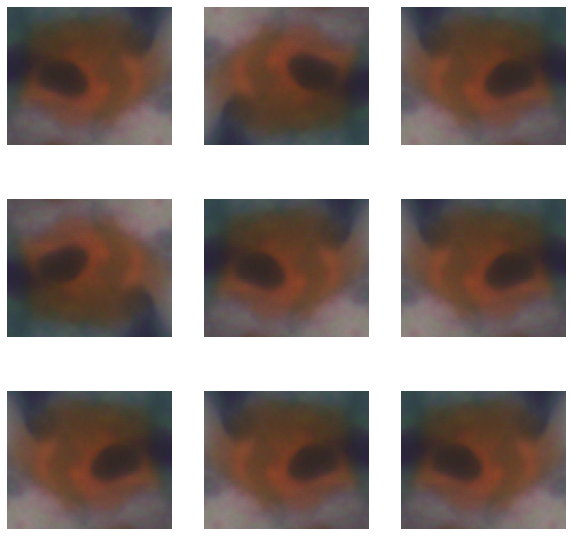

In [4]:
import tensorflow.keras.layers as layers

# -- PREPROCESSING SEQUENCE -- #
normalization_layer = layers.experimental.preprocessing.Rescaling(1. / 255, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
data_augmentation = layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical')

image_path = 'img/005_01.bmp'
image = tf.keras.preprocessing.image.load_img(image_path)
image_arr = keras.preprocessing.image.img_to_array(image)

image_arr = tf.expand_dims(image_arr, 0)

maxValue = np.amax(image_arr)
minValue = np.amin(image_arr)
print(minValue, maxValue)

preprocess = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1. / 255, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical'),
#     layers.experimental.preprocessing.RandomRotation(0.2),
])

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = preprocess(image_arr)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

## Model Architecture and HP Tuning

Model: "CervixNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
xception (Functional)           (None, 8, 8, 2048)   20861480    image[0][0]                      
__________________________________________________________________________________________________
resnet50v2 (Functional)         (None, 8, 8, 2048)   23564800    image[0][0]                      
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 8, 8, 4096)   0           xception[0][0]                   
                                                                 resnet50v2[0][0]         

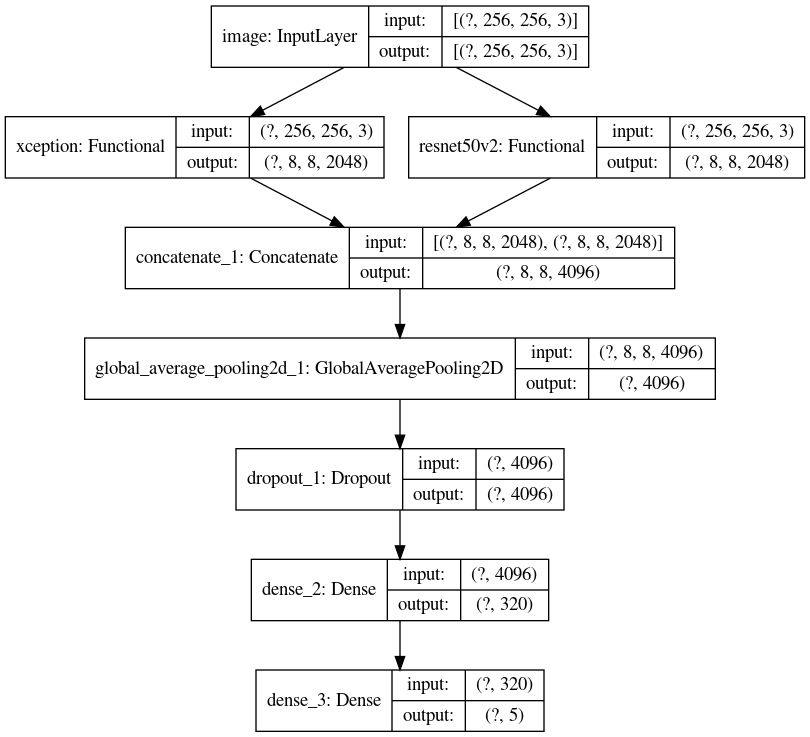

In [6]:
from tensorflow.keras.applications import ResNet50V2, Xception

# -- CONVOLUTIONAL BASE -- #
xception_base = Xception(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
for layer in xception_base.layers[:(len(xception_base.layers) - 16)]:
    layer.trainable = False
# xception_base.summary()
# xception_base.trainable = False

resnet50_base_partial_frozen = ResNet50V2(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
for layer in resnet50_base_partial_frozen.layers[:(len(resnet50_base_partial_frozen.layers) - 36)]:
    layer.trainable = False
# resnet50_base_partial_frozen.trainable = False

inputs = keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3), name='image')
xception_features = xception_base(inputs)
resnet50_features = resnet50_base_partial_frozen(inputs)
concat_features = layers.concatenate([xception_features, resnet50_features])
x = layers.GlobalAveragePooling2D()(concat_features)
x = layers.Dropout(.2, seed=SEED)(x)
x = layers.Dense(320, activation='relu')(x)
out = layers.Dense(NUM_CLASSES, activation='softmax')(x)

concat_model = keras.Model(inputs=inputs, outputs=out, name='CervixNet')
concat_model.summary()
keras.utils.plot_model(concat_model, to_file="img/concat_arch.png", show_shapes=True)

In [14]:
from tensorflow.keras import Sequential
from kerastuner import HyperModel, HyperParameters, RandomSearch

# -- HYPER MODEL -- #
class HyperCervixNet(HyperModel):
    def __init__(self):
        super().__init__()

    def build(self, hp):
        # hp search space
        fc_units1 = hp.Int('fc_units', min_value=256, max_value=1024,
                          step=64, default=256)
        fc_activation1 = hp.Choice('fc_activation',
                                  values=['relu', 'tanh', 'sigmoid'],
                                  default='relu')
        inputs = keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3), name='image')
        xception_features = xception_base(inputs)
        resnet50_features = resnet50_base_partial_frozen(inputs)
        concat_features = layers.concatenate([xception_features, resnet50_features])
        x = layers.GlobalAveragePooling2D()(concat_features)
        x = layers.Dropout(.2, seed=SEED)(x)
        x = layers.Dense(fc_units1, activation=fc_activation1)(x)
        out = layers.Dense(NUM_CLASSES, activation='softmax')(x)

        concat_model = keras.Model(inputs=inputs, outputs=out, name='CervixNet')
        
        # decaying learning rate
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-2,
            decay_steps=10000,
            decay_rate=0.9)
        optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
        # compile the model
        concat_model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])
        return concat_model
    
hypermodel = HyperCervixNet()

In [15]:
import datetime
import time
import json

# -- TUNER -- #
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 1
SEARCH_EPOCHS = 50

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=SEED,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='random_search',
    project_name='concat_net',
)
tuner.search_space_summary()

tuning_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=1e-3, patience=10,
        mode='min', baseline=None, restore_best_weights=True)
]

start = time.time()
tuner.search(train_ds, epochs=SEARCH_EPOCHS, validation_data=val_ds, callbacks=tuning_callbacks)
end = time.time() - start
print('Hyperparameter search time: {}'.format(datetime.timedelta(seconds=end)))
# Show a summary of the search
tuner.results_summary()
best_hp = tuner.get_best_hyperparameters()[0]
with open('concat_best_hp.json', 'w') as f:
    json.dump(best_hp.get_config(), f)
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('concat_best_mt{}_ept{}_se{}.h5'.format(MAX_TRIALS, EXECUTION_PER_TRIAL, SEARCH_EPOCHS))
# Evaluate the best model.
loss, acc = best_model.evaluate(test_ds)
print('Loss: {}\nAccuracy: {}'.format(loss, acc))

INFO:tensorflow:Reloading Oracle from existing project random_search/concat_net/oracle.json
INFO:tensorflow:Reloading Tuner from random_search/concat_net/tuner0.json


INFO:tensorflow:Oracle triggered exit
Hyperparameter search time: 0:00:00.001265


7/7 [==============================] - ETA: 0s - loss: 0.1463 - accuracy: 0.93 - ETA: 1s - loss: 0.1777 - accuracy: 0.90 - ETA: 2s - loss: 0.1210 - accuracy: 0.93 - ETA: 1s - loss: 0.1663 - accuracy: 0.92 - ETA: 1s - loss: 0.1645 - accuracy: 0.93 - ETA: 0s - loss: 0.1874 - accuracy: 0.93 - ETA: 0s - loss: 0.1738 - accuracy: 0.94 - 8s 1s/step - loss: 0.1738 - accuracy: 0.9423
Loss: 0.17382995784282684
Accuracy: 0.942307710647583


## Refitting the Model

Epoch 1/100
102/102 - 151s - loss: 1.5076 - accuracy: 0.7374 - val_loss: 3205.6899 - val_accuracy: 0.5397
Epoch 2/100
102/102 - 117s - loss: 0.4772 - accuracy: 0.8653 - val_loss: 25.5193 - val_accuracy: 0.8576
Epoch 3/100
102/102 - 117s - loss: 0.3405 - accuracy: 0.8947 - val_loss: 1.3495 - val_accuracy: 0.7467
Epoch 4/100
102/102 - 117s - loss: 0.2718 - accuracy: 0.9116 - val_loss: 0.3891 - val_accuracy: 0.8974
Epoch 5/100
102/102 - 117s - loss: 0.2117 - accuracy: 0.9271 - val_loss: 0.4108 - val_accuracy: 0.8758
Epoch 6/100
102/102 - 117s - loss: 0.4549 - accuracy: 0.9212 - val_loss: 0.3854 - val_accuracy: 0.8940
Epoch 7/100
102/102 - 117s - loss: 0.2414 - accuracy: 0.9336 - val_loss: 0.5067 - val_accuracy: 0.9023
Epoch 8/100
102/102 - 117s - loss: 0.1835 - accuracy: 0.9404 - val_loss: 0.2451 - val_accuracy: 0.9321
Epoch 9/100
102/102 - 117s - loss: 0.1790 - accuracy: 0.9534 - val_loss: 0.2762 - val_accuracy: 0.9172
Epoch 10/100
102/102 - 117s - loss: 0.1548 - accuracy: 0.9518 - val_l

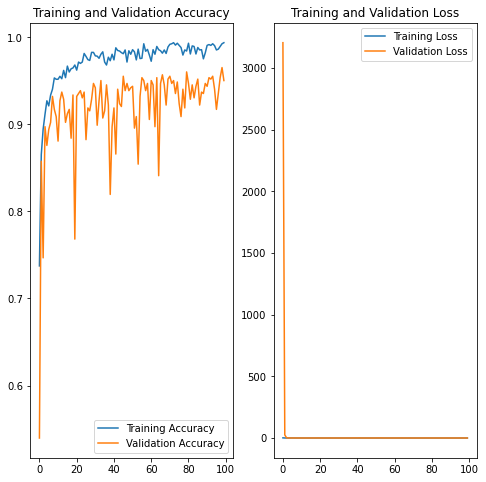

In [16]:
fit_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=1e-4, patience=10,
        mode='min', baseline=None, restore_best_weights=True)
]

# best_model = keras.models.load_model('concat_best_mt20_ept1_se50.h5')

start = time.time()
history = best_model.fit(train_ds, epochs=100, validation_data=val_ds, verbose=2)
end = time.time() - start
print('Refit time: {}'.format(datetime.timedelta(seconds=end)))

n_epochs_best = len(history.history['val_loss'])

filename = 'concat_best_refit_e{}'.format(n_epochs_best)
best_model.save('models/{}.h5'.format(filename))
visualize_result(history, n_epochs_best, 'img/' + filename + '.png')

## Evaluate

In [20]:
labels = list(test_ds.class_indices.keys())
print(labels)

['dyskeratotic', 'koilocytotic', 'metaplastic', 'parabasal', 'superficialIntermediate']


In [46]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=((6, 6)))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(title + '.png')

In [41]:
model = keras.models.load_model('models/concat_best_refit_e100.h5')
y_pred = model.predict(test_ds)

Confusion matrix, without normalization
[[40  1  1  0  0]
 [ 0 42  0  0  0]
 [ 0  2 39  0  0]
 [ 0  0  1 39  0]
 [ 0  0  0  0 43]]


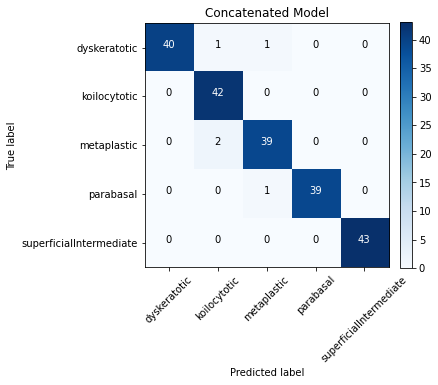

In [47]:
from sklearn.metrics import confusion_matrix
import itertools


rounded_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true=test_ds.classes, y_pred=rounded_pred)
plot_confusion_matrix(cm, labels, title="Concatenated Model")

## Training

In [ ]:
import datetime
import time

fit_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=1e-4, patience=10,
        mode='min', baseline=None, restore_best_weights=True)
]
# decaying learning rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
# compile the model
concat_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

start = time.time()
history = concat_model.fit(train_ds, epochs=100, validation_data=val_ds, verbose=2, callbacks=fit_callbacks)
end = time.time() - start
print('Training time: {}'.format(datetime.timedelta(seconds=end)))

n_epochs_best = len(history.history['val_loss'])
filename = 'concat_fit_e{}'.format(n_epochs_best)
concat_model.save('models/{}.h5'.format(filename))
visualize_result(history, n_epochs_best, 'img/' + filename + '.png')

loss, acc = concat_model.evaluate(test_ds)
print('Loss: {}\nAccuracy: {}'.format(loss, acc))